In [1]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
import re
from ocatari.vision.game_objects import NoObject

from utils import get_env, wrap_recording, image_to_base64, numpy_to_base64, load_demonstrations, frames_to_video, base64_to_numpy

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [3]:
# from google import genai
# client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

In [4]:
from anthropic import Anthropic

client = Anthropic(api_key=os.environ.get("CLAUDE_API_KEY"))

In [5]:
# from openai import OpenAI

# client = OpenAI(
#     api_key=os.getenv("DASHSCOPE_API_KEY"),
#     base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
# )

In [6]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [7]:
# from transformers import AutoProcessor, AutoModelForImageTextToText
# import torch

# smolvlm2_model_path = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
# smolvlm2_processor = AutoProcessor.from_pretrained(smolvlm2_model_path)
# smolvlm2_model = AutoModelForImageTextToText.from_pretrained(
#     smolvlm2_model_path,
#     torch_dtype=torch.bfloat16,
#     _attn_implementation="flash_attention_2"
# ).to("cuda")

In [8]:
def call_smolvlm2(prompt, step, actions):
    content = []
    for s in range(step-2, step+1):
        content.append({"type": "text", "text": f'Step {s}: action: {index_to_action(actions[s][0])} reward {actions[s][1]}'})
        content.append({"type": "image", "url": f'data:image/png;base64,{image_to_base64(f"states/{s}.png")}'})
    content.append({"type": "text", "text": prompt})

    messages = [{
        "role": "user",
        "content": content
    }]

    inputs = smolvlm2_processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(smolvlm2_model.device, dtype=torch.bfloat16)

    generated_ids = smolvlm2_model.generate(**inputs, do_sample=False, max_new_tokens=64)
    generated_texts = smolvlm2_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    res = generated_texts[0]
    print(res)

    match = re.search("<action>(.+)</action>", res)
    if match:
        return match[1]
    else:
        return "NOOP"

In [9]:
def call_gemini(prompt, step, actions, use_expert_demo=False):
    contents = []
    contents.append(f'Expert demonstrations:')
    if use_expert_demo:
        contents.append(Image.fromarray(demonstrations[0][0]))
        for i, (state, action, reward, next_state, done) in enumerate(demonstrations[:50]):
            contents.append(f'Step {i}: action {index_to_action(action)} reward {reward}')
            contents.append(Image.fromarray(next_state))
    contents.append(f'Your previous 4 steps:')
    for s in range(step-2, step+1):
        contents.append(f'Step {s}: action {index_to_action(actions[s][0])} reward {actions[s][1]}')
        contents.append(Image.open(f'states/{s}.png'))
    contents.append(prompt)
    
    print(contents)

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=contents,
        config = {
            'response_mime_type': 'application/json',
            'response_schema': { "type": "OBJECT",
                "properties": {
                    "reasoning": { "type": "STRING", "description": "Step by step reasoning on which action to perform" },
                    "action": { "type": "STRING", "enum": ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"], "description": "Next action to perform" }
                },
                "required": ["reasoning", "action"],
                "propertyOrdering": ["reasoning", "action"]
            }
        }
    )
    response = json.loads(response.text)
    print(response['action'] + ' ' + response['reasoning'])
    return response['action']

In [10]:
def call_claude(prompt, step, actions, frames, demonstrations, resize_to):
    MODEL_NAME = "claude-3-7-sonnet-20250219"
    contents = []
    if len(demonstrations) > 0:
        contents.append({"type": "text", "text": f'Expert demonstrations:'})
        contents.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": numpy_to_base64(demonstrations[0][0], resize_to=resize_to)}})
        for i, (state, action, reward, next_state, done) in enumerate(demonstrations):
            contents.append({"type": "text", "text": f'Step {i}: action {index_to_action(action)} reward {reward}'})
            contents.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": numpy_to_base64(next_state, resize_to=resize_to)}})
        contents.append({"type": "text", "text": f'Your previous 4 steps:'})
    
    buffer = np.array(frames[step])
    for s in range(step, step+1):
        contents.append({"type": "text", "text": f'Step {s}: action {index_to_action(actions[s][0])} reward {actions[s][1]}'})
        contents.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": numpy_to_base64(buffer[s - step - 1], resize_to=resize_to)}})
    contents.append({"type": "text", "text": prompt})

    message_list = [
        {
            "role": 'user',
            "content": contents
        }
    ]
    
    for c in contents:
        if c['type'] == 'text':
            print(c['text'])
        elif c['type'] == 'image':
            import base64
            import io
            from matplotlib import pyplot as plt
            import matplotlib.image as mpimg
            i = base64.b64decode(c['source']['data'].removeprefix('data:image/png;base64,'))
            i = io.BytesIO(i)
            i = mpimg.imread(i, format='PNG')
            plt.figure()
            plt.imshow(i, interpolation='nearest')
            plt.show()

    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=500,
        messages=message_list
    )
    print(response.content[0].text)
    res = re.findall('```json(.+)```', response.content[0].text, re.DOTALL)
    if res:
        res = res[0]
    print(res)
    res = json.loads(res)
    return res['action']


In [11]:
def call_openai(model, reasoning_effort, prompt, step, trace, demonstrations, resize_to, oc):
    content = []

    if len(demonstrations) > 0:
        content.append({"type": "text", "text": f'Expert demonstrations:'})
        content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(demonstrations[0][0], resize_to=resize_to)}'}})
        for i, (state, action, reward, next_state, done) in enumerate(demonstrations):
            content.append({"type": "text", "text": f'Step {i}: action {index_to_action(action)} reward {reward}'})
            content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(next_state, resize_to=resize_to)}'}})

    if oc:
        for s in range(step, step+1):
            content.append({"type": "text", "text": f'\nStep: {s} action: {index_to_action(trace[s]["action"])} Game objects: {objs_to_str(trace[s]["objs"])}'})
            # content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(frames[s][0], resize_to=resize_to)}'}})
        content.append({"type": "text", "text": prompt})
    else:
        buffer = np.array(frames[step])
        for s in range(step, step+1):
            content.append({"type": "text", "text": f'Step: {s} action: {index_to_action(trace[s]["action"])} reward: {trace[s]["reward"]}'})
            content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(buffer[s - step - 1], resize_to=resize_to)}'}})
        content.append({"type": "text", "text": prompt})

    for c in content:
        if c['type'] == 'text':
            print(c['text'])
        elif c['type'] == 'image_url':
            import base64
            import io
            from matplotlib import pyplot as plt
            import matplotlib.image as mpimg
            i = base64.b64decode(c['image_url']['url'].removeprefix('data:image/png;base64,'))
            i = io.BytesIO(i)
            i = mpimg.imread(i, format='PNG')
            plt.figure()
            plt.imshow(i, interpolation='nearest')
            plt.show()

    message_list = [
        {
            "role": 'user',
            "content": content
        }
    ]
    completion = client.chat.completions.create(
        # model='gpt-4o-2024-11-20',
        # model='o1-2024-12-17',
        model=model,
        reasoning_effort=reasoning_effort,
        messages=message_list,
        response_format={ "type": "json_schema", "json_schema": {
            "name": "pick_next_action",
            "strict": True,
            "schema": {
                "type": "object",
                "properties": {
                    "game_state": { "type": "string" },
                    "reasoning": { "type": "string" },
                    "action": {
                        "type": "string",
                        "description": "next action",
                        "enum": ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"]
                    }
                },
                "additionalProperties": False,
                "required": ["game_state", "reasoning", "action"]
            }
        }}
    )
    res = completion.choices[0].message.content
    res = json.loads(res)
    return res['action'], message_list, res


In [2]:
def extract_objs(env):
    return [{'name': obj.__class__.__name__, 'x': obj.x, 'y': obj.y, 'w': obj.w, 'h': obj.h} for obj in env.objects if obj != NoObject() and obj.visible]

def objs_to_str(objs):
    return ', '.join(f"{obj['name']} at ({obj['x']}, {obj['y']}) size ({obj['w']}, {obj['h']})" for obj in objs)

In [2]:
import json
import enum
import os

process_images = False
# resize_to = (1024, 1024)
resize_to = None
reasoning_effort = 'low'
env = get_env(process=process_images, oc=True)
# wrap_recording(env, video_folder='gpt4o', episode_trigger=lambda x: True, name_prefix='zeroshot')
model = 'o3-mini-2025-01-31'

os.makedirs('traces', exist_ok=True)

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]



Step: 108 action: NOOP Game objects: Frog at (79, 171) size (7, 7), Car at (34, 161) size (8, 7), Car at (114, 161) size (8, 7), Car at (73, 148) size (8, 7), Car at (62, 135) size (8, 7), Car at (30, 135) size (8, 7), Car at (142, 135) size (8, 7), Car at (110, 135) size (8, 7), Car at (67, 122) size (8, 7), Car at (147, 122) size (5, 7), Car at (112, 109) size (16, 7), Car at (32, 109) size (16, 7), Log at (86, 70) size (16, 7), Log at (54, 70) size (16, 7), Log at (22, 70) size (16, 7), Log at (136, 57) size (16, 7), Log at (8, 57) size (32, 7), Log at (95, 31) size (32, 7), Log at (15, 31) size (32, 7), Turtle at (38, 83) size (8, 7), Turtle at (70, 83) size (8, 7), Turtle at (54, 83) size (8, 7), Turtle at (136, 44) size (8, 7), Turtle at (92, 44) size (8, 7), Turtle at (76, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and heigh

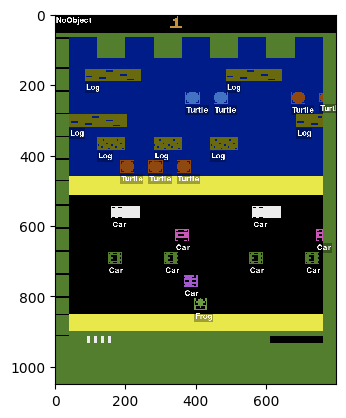


Step: 109 action: UP Game objects: Frog at (79, 161) size (7, 7), Car at (73, 148) size (8, 7), Car at (62, 135) size (8, 7), Car at (30, 135) size (8, 7), Car at (142, 135) size (8, 7), Car at (110, 135) size (8, 7), Car at (68, 122) size (8, 7), Car at (148, 122) size (4, 7), Car at (112, 109) size (16, 7), Car at (32, 109) size (16, 7), Log at (88, 70) size (16, 7), Log at (56, 70) size (16, 7), Log at (24, 70) size (16, 7), Log at (137, 57) size (15, 7), Log at (8, 57) size (33, 7), Log at (97, 31) size (32, 7), Log at (17, 31) size (32, 7), Turtle at (37, 83) size (8, 7), Turtle at (69, 83) size (8, 7), Turtle at (53, 83) size (8, 7), Turtle at (150, 45) size (2, 5), Turtle at (134, 44) size (8, 7), Turtle at (90, 44) size (8, 7), Turtle at (74, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to p

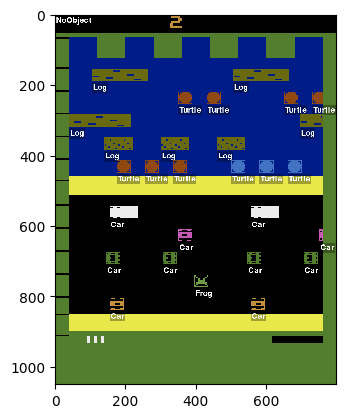


Step: 110 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (111, 161) size (8, 7), Car at (31, 161) size (8, 7), Car at (61, 135) size (8, 7), Car at (29, 135) size (8, 7), Car at (141, 135) size (8, 7), Car at (109, 135) size (8, 7), Car at (70, 122) size (8, 7), Car at (150, 122) size (2, 7), Car at (111, 109) size (16, 7), Car at (31, 109) size (16, 7), Log at (92, 70) size (16, 7), Log at (60, 70) size (16, 7), Log at (28, 70) size (16, 7), Log at (139, 57) size (13, 7), Log at (8, 57) size (35, 7), Log at (101, 31) size (32, 7), Log at (21, 31) size (32, 7), Turtle at (35, 83) size (8, 7), Turtle at (67, 83) size (8, 7), Turtle at (51, 83) size (8, 7), Turtle at (132, 83) size (8, 7), Turtle at (116, 83) size (8, 7), Turtle at (100, 83) size (8, 7), Turtle at (146, 44) size (6, 7), Turtle at (130, 44) size (8, 7), Turtle at (86, 44) size (8, 7), Turtle at (70, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The

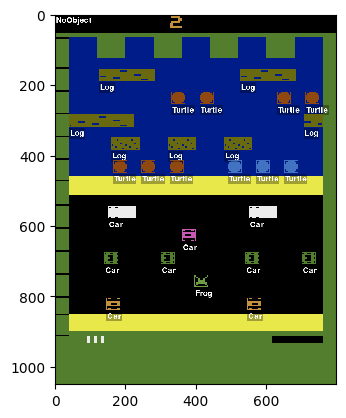


Step: 111 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (109, 161) size (8, 7), Car at (29, 161) size (8, 7), Car at (60, 135) size (8, 7), Car at (28, 135) size (8, 7), Car at (140, 135) size (8, 7), Car at (108, 135) size (8, 7), Car at (72, 122) size (8, 7), Car at (110, 109) size (16, 7), Car at (30, 109) size (16, 7), Log at (96, 70) size (16, 7), Log at (64, 70) size (16, 7), Log at (32, 70) size (16, 7), Log at (141, 57) size (11, 7), Log at (8, 57) size (37, 7), Log at (105, 31) size (32, 7), Log at (25, 31) size (32, 7), Turtle at (33, 83) size (8, 7), Turtle at (65, 83) size (8, 7), Turtle at (49, 83) size (8, 7), Turtle at (130, 83) size (8, 7), Turtle at (114, 83) size (8, 7), Turtle at (98, 83) size (8, 7), Turtle at (142, 44) size (8, 7), Turtle at (126, 44) size (8, 7), Turtle at (82, 44) size (8, 7), Turtle at (66, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their

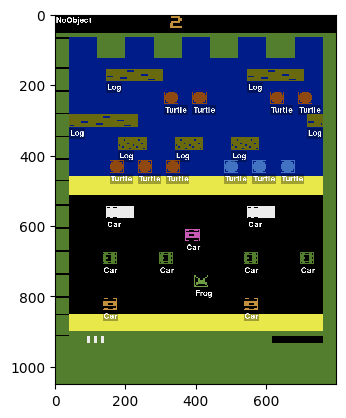


Step: 112 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (107, 161) size (8, 7), Car at (27, 161) size (8, 7), Car at (59, 135) size (8, 7), Car at (27, 135) size (8, 7), Car at (139, 135) size (8, 7), Car at (107, 135) size (8, 7), Car at (74, 122) size (8, 7), Car at (109, 109) size (16, 7), Car at (29, 109) size (16, 7), Log at (100, 70) size (16, 7), Log at (68, 70) size (16, 7), Log at (36, 70) size (16, 7), Log at (143, 57) size (9, 7), Log at (8, 57) size (39, 7), Log at (109, 31) size (32, 7), Log at (29, 31) size (32, 7), Turtle at (31, 83) size (8, 7), Turtle at (63, 83) size (8, 7), Turtle at (47, 83) size (8, 7), Turtle at (128, 83) size (8, 7), Turtle at (112, 83) size (8, 7), Turtle at (96, 83) size (8, 7), Turtle at (138, 44) size (8, 7), Turtle at (122, 44) size (8, 7), Turtle at (78, 44) size (8, 7), Turtle at (62, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their

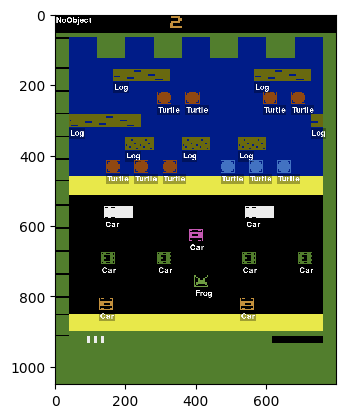


Step: 113 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (105, 161) size (8, 7), Car at (25, 161) size (8, 7), Car at (58, 135) size (8, 7), Car at (26, 135) size (8, 7), Car at (138, 135) size (8, 7), Car at (106, 135) size (8, 7), Car at (76, 122) size (8, 7), Car at (108, 109) size (16, 7), Car at (28, 109) size (16, 7), Log at (104, 70) size (16, 7), Log at (72, 70) size (16, 7), Log at (40, 70) size (16, 7), Log at (145, 57) size (7, 7), Log at (8, 57) size (41, 7), Log at (113, 31) size (32, 7), Log at (33, 31) size (32, 7), Turtle at (29, 83) size (8, 7), Turtle at (61, 83) size (8, 7), Turtle at (45, 83) size (8, 7), Turtle at (126, 83) size (8, 7), Turtle at (110, 83) size (8, 7), Turtle at (94, 83) size (8, 7), Turtle at (134, 44) size (8, 7), Turtle at (118, 44) size (8, 7), Turtle at (74, 44) size (8, 7), Turtle at (58, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their

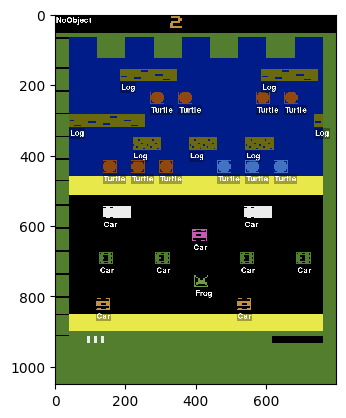


Step: 114 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (103, 161) size (8, 7), Car at (23, 161) size (8, 7), Car at (57, 135) size (8, 7), Car at (25, 135) size (8, 7), Car at (137, 135) size (8, 7), Car at (105, 135) size (8, 7), Car at (78, 122) size (8, 7), Car at (107, 109) size (16, 7), Car at (27, 109) size (16, 7), Log at (108, 70) size (16, 7), Log at (76, 70) size (16, 7), Log at (44, 70) size (16, 7), Log at (147, 57) size (5, 7), Log at (8, 57) size (43, 7), Log at (117, 31) size (32, 7), Log at (37, 31) size (32, 7), Turtle at (27, 83) size (8, 7), Turtle at (59, 83) size (8, 7), Turtle at (43, 83) size (8, 7), Turtle at (124, 83) size (8, 7), Turtle at (108, 83) size (8, 7), Turtle at (92, 83) size (8, 7), Turtle at (130, 44) size (8, 7), Turtle at (114, 44) size (8, 7), Turtle at (70, 44) size (8, 7), Turtle at (54, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their

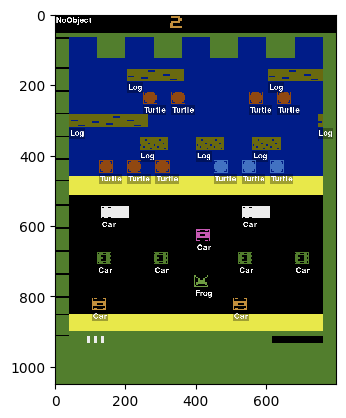


Step: 115 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (101, 161) size (8, 7), Car at (21, 161) size (8, 7), Car at (56, 135) size (8, 7), Car at (24, 135) size (8, 7), Car at (136, 135) size (8, 7), Car at (104, 135) size (8, 7), Car at (80, 122) size (8, 7), Car at (106, 109) size (16, 7), Car at (26, 109) size (16, 7), Log at (112, 70) size (16, 7), Log at (80, 70) size (16, 7), Log at (48, 70) size (16, 7), Log at (149, 57) size (3, 7), Log at (8, 57) size (45, 7), Log at (121, 31) size (31, 7), Log at (41, 31) size (32, 7), Turtle at (25, 83) size (8, 7), Turtle at (57, 83) size (8, 7), Turtle at (41, 83) size (8, 7), Turtle at (122, 83) size (8, 7), Turtle at (106, 83) size (8, 7), Turtle at (90, 83) size (8, 7), Turtle at (126, 44) size (8, 7), Turtle at (110, 44) size (8, 7), Turtle at (66, 44) size (8, 7), Turtle at (50, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their

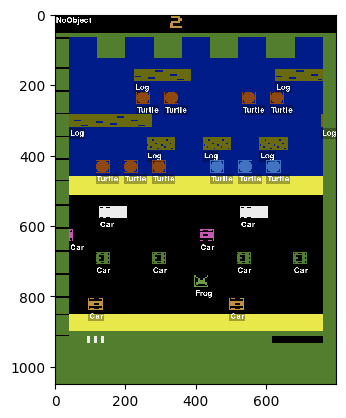


Step: 116 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (99, 161) size (8, 7), Car at (19, 161) size (8, 7), Car at (55, 135) size (8, 7), Car at (23, 135) size (8, 7), Car at (135, 135) size (8, 7), Car at (103, 135) size (8, 7), Car at (82, 122) size (8, 7), Car at (8, 122) size (2, 7), Car at (105, 109) size (16, 7), Car at (25, 109) size (16, 7), Log at (116, 70) size (16, 7), Log at (84, 70) size (16, 7), Log at (52, 70) size (16, 7), Log at (151, 57) size (1, 7), Log at (8, 57) size (47, 7), Log at (125, 31) size (27, 7), Log at (45, 31) size (32, 7), Turtle at (23, 83) size (8, 7), Turtle at (55, 83) size (8, 7), Turtle at (39, 83) size (8, 7), Turtle at (120, 83) size (8, 7), Turtle at (104, 83) size (8, 7), Turtle at (88, 83) size (8, 7), Turtle at (122, 44) size (8, 7), Turtle at (106, 44) size (8, 7), Turtle at (62, 44) size (8, 7), Turtle at (46, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The gam

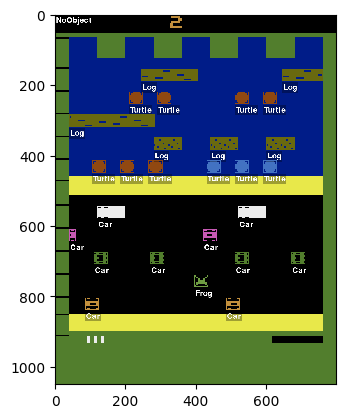


Step: 117 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (97, 161) size (8, 7), Car at (17, 161) size (8, 7), Car at (54, 135) size (8, 7), Car at (22, 135) size (8, 7), Car at (134, 135) size (8, 7), Car at (102, 135) size (8, 7), Car at (84, 122) size (8, 7), Car at (8, 122) size (4, 7), Car at (104, 109) size (16, 7), Car at (24, 109) size (16, 7), Log at (120, 70) size (16, 7), Log at (88, 70) size (16, 7), Log at (56, 70) size (16, 7), Log at (8, 57) size (49, 7), Log at (129, 31) size (23, 7), Log at (49, 31) size (32, 7), Turtle at (21, 83) size (8, 7), Turtle at (53, 83) size (8, 7), Turtle at (37, 83) size (8, 7), Turtle at (118, 83) size (8, 7), Turtle at (102, 83) size (8, 7), Turtle at (86, 83) size (8, 7), Turtle at (118, 44) size (8, 7), Turtle at (102, 44) size (8, 7), Turtle at (58, 44) size (8, 7), Turtle at (42, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their t

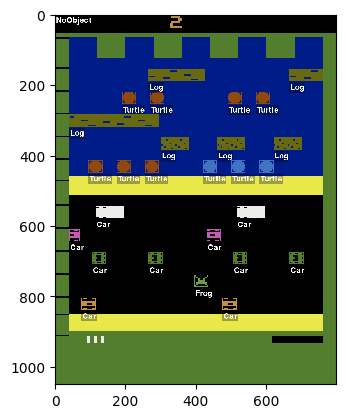


Step: 118 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (95, 161) size (8, 7), Car at (15, 161) size (8, 7), Car at (53, 135) size (8, 7), Car at (21, 135) size (8, 7), Car at (133, 135) size (8, 7), Car at (101, 135) size (8, 7), Car at (86, 122) size (8, 7), Car at (8, 122) size (6, 7), Car at (103, 109) size (16, 7), Car at (23, 109) size (16, 7), Log at (124, 70) size (16, 7), Log at (92, 70) size (16, 7), Log at (60, 70) size (16, 7), Log at (8, 57) size (51, 7), Log at (133, 31) size (19, 7), Log at (53, 31) size (32, 7), Turtle at (19, 83) size (8, 7), Turtle at (51, 83) size (8, 7), Turtle at (35, 83) size (8, 7), Turtle at (116, 83) size (8, 7), Turtle at (100, 83) size (8, 7), Turtle at (84, 83) size (8, 7), Turtle at (114, 44) size (8, 7), Turtle at (98, 44) size (8, 7), Turtle at (54, 44) size (8, 7), Turtle at (38, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their to

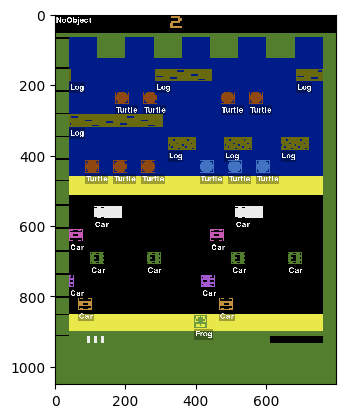


Step: 119 action: UP Game objects: Frog at (79, 171) size (7, 7), Car at (93, 161) size (8, 7), Car at (13, 161) size (8, 7), Car at (8, 148) size (3, 7), Car at (83, 148) size (8, 7), Car at (52, 135) size (8, 7), Car at (20, 135) size (8, 7), Car at (132, 135) size (8, 7), Car at (100, 135) size (8, 7), Car at (88, 122) size (8, 7), Car at (8, 122) size (8, 7), Car at (102, 109) size (16, 7), Car at (22, 109) size (16, 7), Log at (128, 70) size (16, 7), Log at (96, 70) size (16, 7), Log at (64, 70) size (16, 7), Log at (8, 57) size (53, 7), Log at (137, 31) size (15, 7), Log at (57, 31) size (32, 7), Log at (8, 31) size (1, 7), Turtle at (17, 83) size (8, 7), Turtle at (49, 83) size (8, 7), Turtle at (33, 83) size (8, 7), Turtle at (114, 83) size (8, 7), Turtle at (98, 83) size (8, 7), Turtle at (82, 83) size (8, 7), Turtle at (110, 44) size (8, 7), Turtle at (94, 44) size (8, 7), Turtle at (50, 44) size (8, 7), Turtle at (34, 44) size (8, 7)
You are a game playing assistant and wil

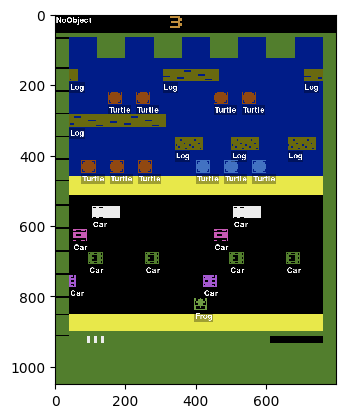


Step: 120 action: UP Game objects: Frog at (79, 161) size (7, 7), Car at (8, 148) size (4, 7), Car at (84, 148) size (8, 7), Car at (51, 135) size (8, 7), Car at (19, 135) size (8, 7), Car at (131, 135) size (8, 7), Car at (99, 135) size (8, 7), Car at (90, 122) size (8, 7), Car at (10, 122) size (8, 7), Car at (101, 109) size (16, 7), Car at (21, 109) size (16, 7), Log at (132, 70) size (16, 7), Log at (100, 70) size (16, 7), Log at (68, 70) size (16, 7), Log at (8, 57) size (55, 7), Log at (141, 31) size (11, 7), Log at (61, 31) size (32, 7), Log at (8, 31) size (5, 7), Turtle at (15, 83) size (8, 7), Turtle at (47, 83) size (8, 7), Turtle at (31, 83) size (8, 7), Turtle at (112, 83) size (8, 7), Turtle at (96, 83) size (8, 7), Turtle at (80, 83) size (8, 7), Turtle at (106, 44) size (8, 7), Turtle at (90, 44) size (8, 7), Turtle at (46, 44) size (8, 7), Turtle at (30, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game ob

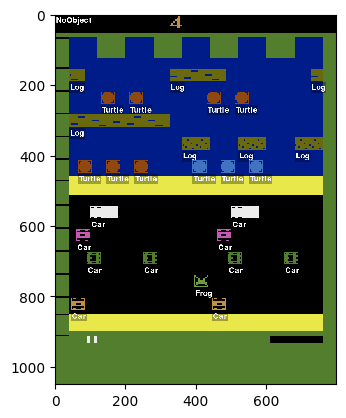


Step: 121 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (89, 161) size (8, 7), Car at (9, 161) size (8, 7), Car at (50, 135) size (8, 7), Car at (18, 135) size (8, 7), Car at (130, 135) size (8, 7), Car at (98, 135) size (8, 7), Car at (92, 122) size (8, 7), Car at (12, 122) size (8, 7), Car at (100, 109) size (16, 7), Car at (20, 109) size (16, 7), Log at (136, 70) size (16, 7), Log at (104, 70) size (16, 7), Log at (72, 70) size (16, 7), Log at (8, 57) size (57, 7), Log at (145, 31) size (7, 7), Log at (65, 31) size (32, 7), Log at (8, 31) size (9, 7), Turtle at (13, 83) size (8, 7), Turtle at (45, 83) size (8, 7), Turtle at (29, 83) size (8, 7), Turtle at (110, 83) size (8, 7), Turtle at (94, 83) size (8, 7), Turtle at (78, 83) size (8, 7), Turtle at (102, 44) size (8, 7), Turtle at (86, 44) size (8, 7), Turtle at (42, 44) size (8, 7), Turtle at (26, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game obj

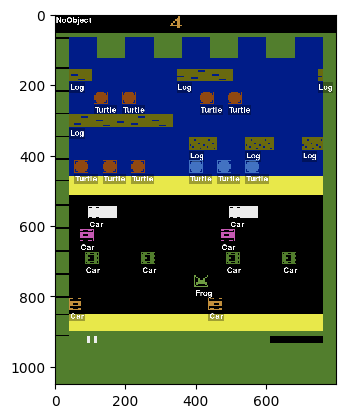


Step: 122 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (87, 161) size (8, 7), Car at (8, 161) size (7, 7), Car at (49, 135) size (8, 7), Car at (17, 135) size (8, 7), Car at (129, 135) size (8, 7), Car at (97, 135) size (8, 7), Car at (94, 122) size (8, 7), Car at (14, 122) size (8, 7), Car at (99, 109) size (16, 7), Car at (19, 109) size (16, 7), Log at (140, 70) size (12, 7), Log at (108, 70) size (16, 7), Log at (76, 70) size (16, 7), Log at (8, 57) size (59, 7), Log at (149, 31) size (3, 7), Log at (69, 31) size (32, 7), Log at (8, 31) size (13, 7), Turtle at (11, 83) size (8, 7), Turtle at (43, 83) size (8, 7), Turtle at (27, 83) size (8, 7), Turtle at (108, 83) size (8, 7), Turtle at (92, 83) size (8, 7), Turtle at (76, 83) size (8, 7), Turtle at (98, 44) size (8, 7), Turtle at (82, 44) size (8, 7), Turtle at (38, 44) size (8, 7), Turtle at (22, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game obje

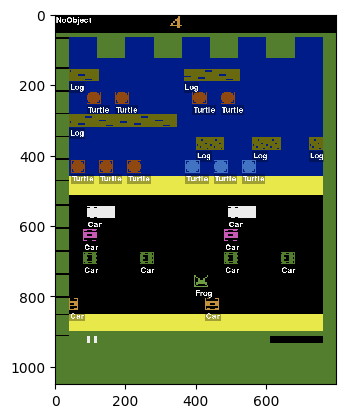


Step: 123 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (85, 161) size (8, 7), Car at (8, 161) size (5, 7), Car at (48, 135) size (8, 7), Car at (16, 135) size (8, 7), Car at (128, 135) size (8, 7), Car at (96, 135) size (8, 7), Car at (96, 122) size (8, 7), Car at (16, 122) size (8, 7), Car at (98, 109) size (16, 7), Car at (18, 109) size (16, 7), Log at (144, 70) size (8, 7), Log at (112, 70) size (16, 7), Log at (80, 70) size (16, 7), Log at (8, 57) size (61, 7), Log at (73, 31) size (32, 7), Log at (8, 31) size (17, 7), Turtle at (9, 83) size (8, 7), Turtle at (41, 83) size (8, 7), Turtle at (25, 83) size (8, 7), Turtle at (106, 83) size (8, 7), Turtle at (90, 83) size (8, 7), Turtle at (74, 83) size (8, 7), Turtle at (94, 44) size (8, 7), Turtle at (78, 44) size (8, 7), Turtle at (34, 44) size (8, 7), Turtle at (18, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left 

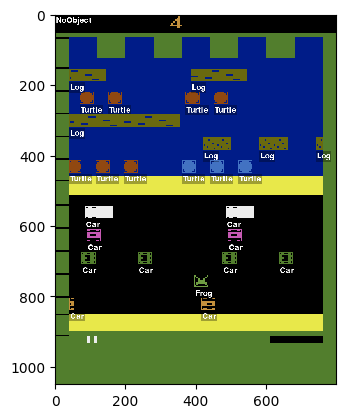


Step: 124 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (83, 161) size (8, 7), Car at (8, 161) size (3, 7), Car at (47, 135) size (8, 7), Car at (15, 135) size (8, 7), Car at (127, 135) size (8, 7), Car at (95, 135) size (8, 7), Car at (98, 122) size (8, 7), Car at (18, 122) size (8, 7), Car at (97, 109) size (16, 7), Car at (17, 109) size (16, 7), Log at (148, 70) size (4, 7), Log at (116, 70) size (16, 7), Log at (84, 70) size (16, 7), Log at (8, 57) size (63, 7), Log at (77, 31) size (32, 7), Log at (8, 31) size (21, 7), Turtle at (8, 83) size (7, 7), Turtle at (39, 83) size (8, 7), Turtle at (23, 83) size (8, 7), Turtle at (104, 83) size (8, 7), Turtle at (88, 83) size (8, 7), Turtle at (72, 83) size (8, 7), Turtle at (90, 44) size (8, 7), Turtle at (74, 44) size (8, 7), Turtle at (30, 44) size (8, 7), Turtle at (14, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left 

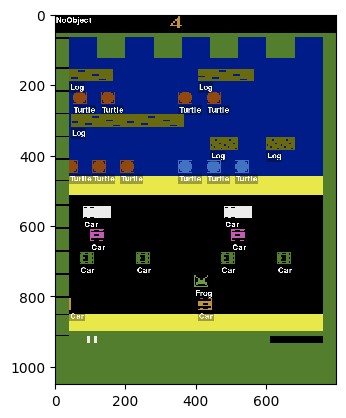


Step: 125 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (81, 161) size (8, 7), Car at (8, 161) size (1, 7), Car at (46, 135) size (8, 7), Car at (14, 135) size (8, 7), Car at (126, 135) size (8, 7), Car at (94, 135) size (8, 7), Car at (100, 122) size (8, 7), Car at (20, 122) size (8, 7), Car at (96, 109) size (16, 7), Car at (16, 109) size (16, 7), Log at (120, 70) size (16, 7), Log at (88, 70) size (16, 7), Log at (9, 57) size (64, 7), Log at (81, 31) size (32, 7), Log at (8, 31) size (25, 7), Turtle at (8, 83) size (5, 7), Turtle at (37, 83) size (8, 7), Turtle at (21, 83) size (8, 7), Turtle at (102, 83) size (8, 7), Turtle at (86, 83) size (8, 7), Turtle at (70, 83) size (8, 7), Turtle at (86, 44) size (8, 7), Turtle at (70, 44) size (8, 7), Turtle at (26, 44) size (8, 7), Turtle at (10, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions fol

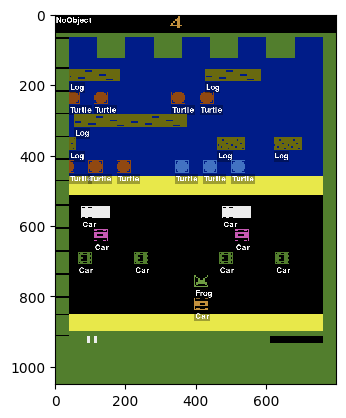


Step: 126 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (79, 161) size (8, 7), Car at (45, 135) size (8, 7), Car at (13, 135) size (8, 7), Car at (125, 135) size (8, 7), Car at (93, 135) size (8, 7), Car at (102, 122) size (8, 7), Car at (22, 122) size (8, 7), Car at (95, 109) size (16, 7), Car at (15, 109) size (16, 7), Log at (8, 70) size (4, 7), Log at (124, 70) size (16, 7), Log at (92, 70) size (16, 7), Log at (11, 57) size (64, 7), Log at (85, 31) size (32, 7), Log at (8, 31) size (29, 7), Turtle at (8, 83) size (3, 7), Turtle at (35, 83) size (8, 7), Turtle at (19, 83) size (8, 7), Turtle at (100, 83) size (8, 7), Turtle at (84, 83) size (8, 7), Turtle at (68, 83) size (8, 7), Turtle at (82, 44) size (8, 7), Turtle at (66, 44) size (8, 7), Turtle at (22, 44) size (8, 7), Turtle at (8, 44) size (6, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions foll

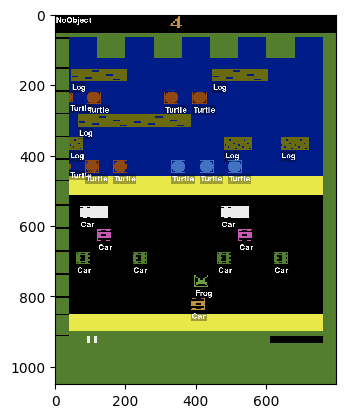


Step: 127 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (77, 161) size (8, 7), Car at (44, 135) size (8, 7), Car at (12, 135) size (8, 7), Car at (124, 135) size (8, 7), Car at (92, 135) size (8, 7), Car at (104, 122) size (8, 7), Car at (24, 122) size (8, 7), Car at (94, 109) size (16, 7), Car at (14, 109) size (16, 7), Log at (8, 70) size (8, 7), Log at (128, 70) size (16, 7), Log at (96, 70) size (16, 7), Log at (13, 57) size (64, 7), Log at (89, 31) size (32, 7), Log at (9, 31) size (32, 7), Turtle at (8, 85) size (1, 3), Turtle at (33, 83) size (8, 7), Turtle at (17, 83) size (8, 7), Turtle at (98, 83) size (8, 7), Turtle at (82, 83) size (8, 7), Turtle at (66, 83) size (8, 7), Turtle at (78, 44) size (8, 7), Turtle at (62, 44) size (8, 7), Turtle at (18, 44) size (8, 7), Turtle at (8, 45) size (2, 5)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions follo

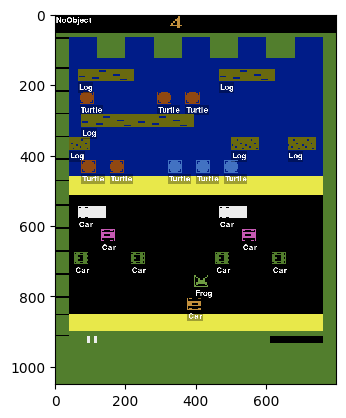


Step: 128 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (75, 161) size (8, 7), Car at (43, 135) size (8, 7), Car at (11, 135) size (8, 7), Car at (123, 135) size (8, 7), Car at (91, 135) size (8, 7), Car at (106, 122) size (8, 7), Car at (26, 122) size (8, 7), Car at (93, 109) size (16, 7), Car at (13, 109) size (16, 7), Log at (8, 70) size (12, 7), Log at (132, 70) size (16, 7), Log at (100, 70) size (16, 7), Log at (15, 57) size (64, 7), Log at (93, 31) size (32, 7), Log at (13, 31) size (32, 7), Turtle at (31, 83) size (8, 7), Turtle at (15, 83) size (8, 7), Turtle at (96, 83) size (8, 7), Turtle at (80, 83) size (8, 7), Turtle at (64, 83) size (8, 7), Turtle at (74, 44) size (8, 7), Turtle at (58, 44) size (8, 7), Turtle at (14, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to pr

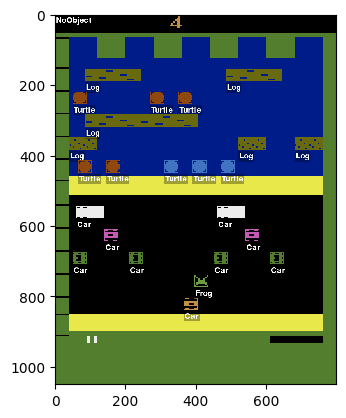


Step: 129 action: UP Game objects: Frog at (79, 148) size (8, 7), Car at (73, 161) size (8, 7), Car at (42, 135) size (8, 7), Car at (10, 135) size (8, 7), Car at (122, 135) size (8, 7), Car at (90, 135) size (8, 7), Car at (108, 122) size (8, 7), Car at (28, 122) size (8, 7), Car at (92, 109) size (16, 7), Car at (12, 109) size (16, 7), Log at (8, 70) size (16, 7), Log at (136, 70) size (16, 7), Log at (104, 70) size (16, 7), Log at (17, 57) size (64, 7), Log at (97, 31) size (32, 7), Log at (17, 31) size (32, 7), Turtle at (29, 83) size (8, 7), Turtle at (13, 83) size (8, 7), Turtle at (94, 83) size (8, 7), Turtle at (78, 83) size (8, 7), Turtle at (62, 83) size (8, 7), Turtle at (70, 44) size (8, 7), Turtle at (54, 44) size (8, 7), Turtle at (10, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to pr

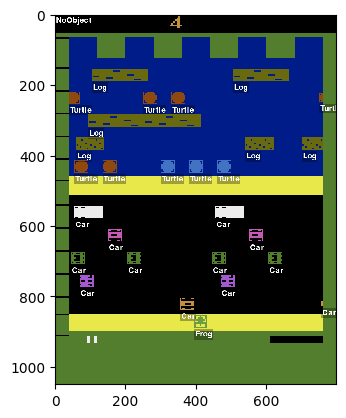


Step: 130 action: UP Game objects: Frog at (79, 171) size (7, 7), Car at (71, 161) size (8, 7), Car at (151, 163) size (1, 3), Car at (94, 148) size (8, 7), Car at (14, 148) size (8, 7), Car at (41, 135) size (8, 7), Car at (9, 135) size (8, 7), Car at (121, 135) size (8, 7), Car at (89, 135) size (8, 7), Car at (110, 122) size (8, 7), Car at (30, 122) size (8, 7), Car at (91, 109) size (16, 7), Car at (11, 109) size (16, 7), Log at (12, 70) size (16, 7), Log at (140, 70) size (12, 7), Log at (108, 70) size (16, 7), Log at (19, 57) size (64, 7), Log at (101, 31) size (32, 7), Log at (21, 31) size (32, 7), Turtle at (27, 83) size (8, 7), Turtle at (11, 83) size (8, 7), Turtle at (92, 83) size (8, 7), Turtle at (76, 83) size (8, 7), Turtle at (60, 83) size (8, 7), Turtle at (66, 44) size (8, 7), Turtle at (50, 44) size (8, 7), Turtle at (8, 44) size (6, 7), Turtle at (150, 45) size (2, 5)
You are a game playing assistant and will be provided the position of all game objects. The game ob

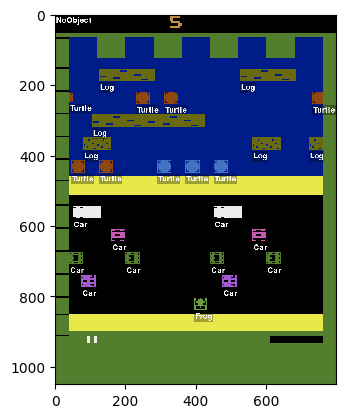


Step: 131 action: UP Game objects: Frog at (79, 161) size (7, 7), Car at (95, 148) size (8, 7), Car at (15, 148) size (8, 7), Car at (40, 135) size (8, 7), Car at (8, 135) size (8, 7), Car at (120, 135) size (8, 7), Car at (88, 135) size (8, 7), Car at (112, 122) size (8, 7), Car at (32, 122) size (8, 7), Car at (90, 109) size (16, 7), Car at (10, 109) size (16, 7), Log at (16, 70) size (16, 7), Log at (144, 70) size (8, 7), Log at (112, 70) size (16, 7), Log at (21, 57) size (64, 7), Log at (105, 31) size (32, 7), Log at (25, 31) size (32, 7), Turtle at (25, 83) size (8, 7), Turtle at (9, 83) size (8, 7), Turtle at (90, 83) size (8, 7), Turtle at (74, 83) size (8, 7), Turtle at (58, 83) size (8, 7), Turtle at (62, 44) size (8, 7), Turtle at (46, 44) size (8, 7), Turtle at (8, 45) size (2, 5), Turtle at (146, 44) size (6, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions fol

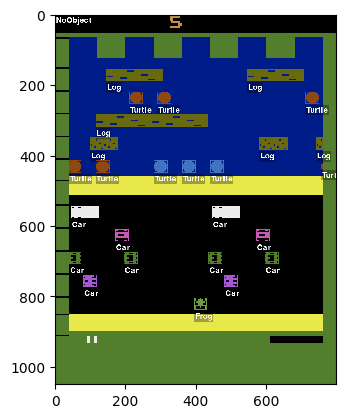


Step: 132 action: UP Game objects: Frog at (79, 161) size (7, 7), Car at (96, 148) size (8, 7), Car at (16, 148) size (8, 7), Car at (39, 135) size (8, 7), Car at (8, 135) size (7, 7), Car at (119, 135) size (8, 7), Car at (87, 135) size (8, 7), Car at (114, 122) size (8, 7), Car at (34, 122) size (8, 7), Car at (89, 109) size (16, 7), Car at (9, 109) size (16, 7), Log at (20, 70) size (16, 7), Log at (148, 70) size (4, 7), Log at (116, 70) size (16, 7), Log at (23, 57) size (64, 7), Log at (109, 31) size (32, 7), Log at (29, 31) size (32, 7), Turtle at (151, 85) size (1, 3), Turtle at (23, 83) size (8, 7), Turtle at (8, 83) size (7, 7), Turtle at (88, 83) size (8, 7), Turtle at (72, 83) size (8, 7), Turtle at (56, 83) size (8, 7), Turtle at (58, 44) size (8, 7), Turtle at (42, 44) size (8, 7), Turtle at (142, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions fo

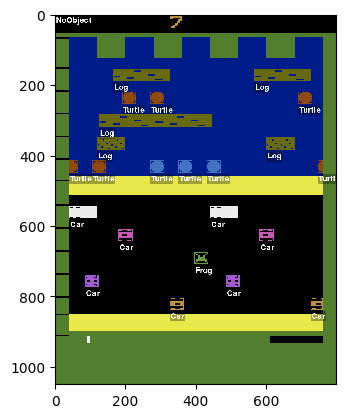


Step: 133 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (145, 161) size (7, 7), Car at (65, 161) size (8, 7), Car at (97, 148) size (8, 7), Car at (17, 148) size (8, 7), Car at (116, 122) size (8, 7), Car at (36, 122) size (8, 7), Car at (88, 109) size (16, 7), Car at (8, 109) size (16, 7), Log at (24, 70) size (16, 7), Log at (120, 70) size (16, 7), Log at (25, 57) size (64, 7), Log at (113, 31) size (32, 7), Log at (33, 31) size (32, 7), Turtle at (149, 83) size (3, 7), Turtle at (21, 83) size (8, 7), Turtle at (8, 83) size (5, 7), Turtle at (86, 83) size (8, 7), Turtle at (70, 83) size (8, 7), Turtle at (54, 83) size (8, 7), Turtle at (54, 44) size (8, 7), Turtle at (38, 44) size (8, 7), Turtle at (138, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you beli

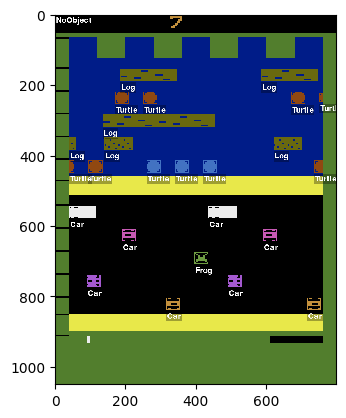


Step: 134 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (143, 161) size (8, 7), Car at (63, 161) size (8, 7), Car at (98, 148) size (8, 7), Car at (18, 148) size (8, 7), Car at (118, 122) size (8, 7), Car at (38, 122) size (8, 7), Car at (87, 109) size (16, 7), Car at (8, 109) size (15, 7), Log at (28, 70) size (16, 7), Log at (8, 70) size (4, 7), Log at (124, 70) size (16, 7), Log at (27, 57) size (64, 7), Log at (117, 31) size (32, 7), Log at (37, 31) size (32, 7), Turtle at (147, 83) size (5, 7), Turtle at (19, 83) size (8, 7), Turtle at (8, 83) size (3, 7), Turtle at (84, 83) size (8, 7), Turtle at (68, 83) size (8, 7), Turtle at (52, 83) size (8, 7), Turtle at (50, 44) size (8, 7), Turtle at (34, 44) size (8, 7), Turtle at (150, 45) size (2, 5), Turtle at (134, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and he

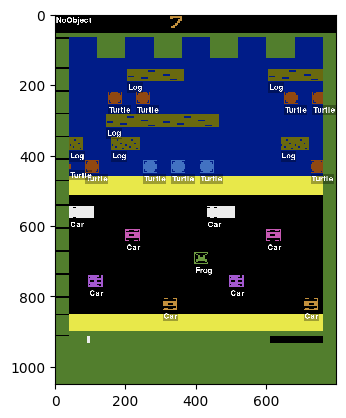


Step: 135 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (141, 161) size (8, 7), Car at (61, 161) size (8, 7), Car at (99, 148) size (8, 7), Car at (19, 148) size (8, 7), Car at (120, 122) size (8, 7), Car at (40, 122) size (8, 7), Car at (86, 109) size (16, 7), Car at (8, 109) size (14, 7), Log at (32, 70) size (16, 7), Log at (8, 70) size (8, 7), Log at (128, 70) size (16, 7), Log at (29, 57) size (64, 7), Log at (121, 31) size (31, 7), Log at (41, 31) size (32, 7), Turtle at (145, 83) size (7, 7), Turtle at (17, 83) size (8, 7), Turtle at (8, 85) size (1, 3), Turtle at (82, 83) size (8, 7), Turtle at (66, 83) size (8, 7), Turtle at (50, 83) size (8, 7), Turtle at (46, 44) size (8, 7), Turtle at (30, 44) size (8, 7), Turtle at (146, 44) size (6, 7), Turtle at (130, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and he

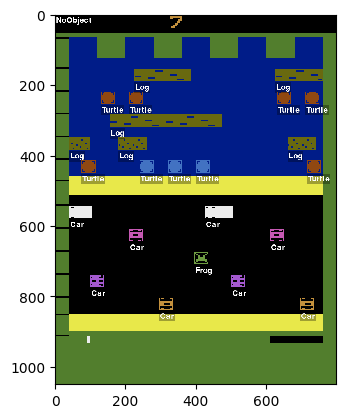


Step: 136 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (139, 161) size (8, 7), Car at (59, 161) size (8, 7), Car at (100, 148) size (8, 7), Car at (20, 148) size (8, 7), Car at (122, 122) size (8, 7), Car at (42, 122) size (8, 7), Car at (85, 109) size (16, 7), Car at (8, 109) size (13, 7), Log at (36, 70) size (16, 7), Log at (8, 70) size (12, 7), Log at (132, 70) size (16, 7), Log at (31, 57) size (64, 7), Log at (125, 31) size (27, 7), Log at (45, 31) size (32, 7), Turtle at (143, 83) size (8, 7), Turtle at (15, 83) size (8, 7), Turtle at (80, 83) size (8, 7), Turtle at (64, 83) size (8, 7), Turtle at (48, 83) size (8, 7), Turtle at (42, 44) size (8, 7), Turtle at (26, 44) size (8, 7), Turtle at (142, 44) size (8, 7), Turtle at (126, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is 

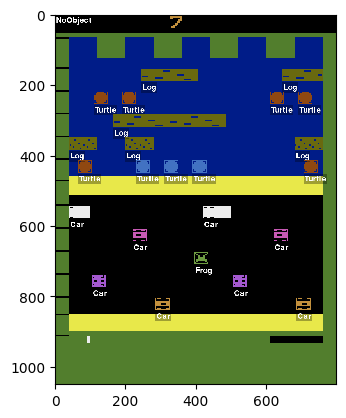


Step: 137 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (137, 161) size (8, 7), Car at (57, 161) size (8, 7), Car at (101, 148) size (8, 7), Car at (21, 148) size (8, 7), Car at (124, 122) size (8, 7), Car at (44, 122) size (8, 7), Car at (84, 109) size (16, 7), Car at (8, 109) size (12, 7), Log at (40, 70) size (16, 7), Log at (8, 70) size (16, 7), Log at (136, 70) size (16, 7), Log at (33, 57) size (64, 7), Log at (129, 31) size (23, 7), Log at (49, 31) size (32, 7), Turtle at (141, 83) size (8, 7), Turtle at (13, 83) size (8, 7), Turtle at (78, 83) size (8, 7), Turtle at (62, 83) size (8, 7), Turtle at (46, 83) size (8, 7), Turtle at (38, 44) size (8, 7), Turtle at (22, 44) size (8, 7), Turtle at (138, 44) size (8, 7), Turtle at (122, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is 

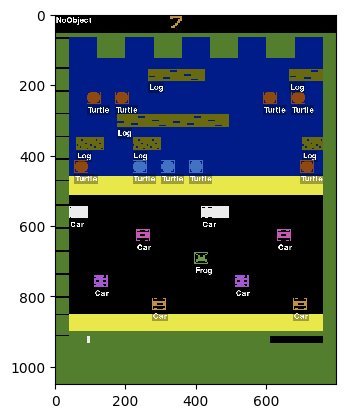


Step: 138 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (135, 161) size (8, 7), Car at (55, 161) size (8, 7), Car at (102, 148) size (8, 7), Car at (22, 148) size (8, 7), Car at (126, 122) size (8, 7), Car at (46, 122) size (8, 7), Car at (83, 109) size (16, 7), Car at (8, 109) size (11, 7), Log at (44, 70) size (16, 7), Log at (12, 70) size (16, 7), Log at (140, 70) size (12, 7), Log at (35, 57) size (64, 7), Log at (133, 31) size (19, 7), Log at (53, 31) size (32, 7), Turtle at (139, 83) size (8, 7), Turtle at (11, 83) size (8, 7), Turtle at (76, 83) size (8, 7), Turtle at (60, 83) size (8, 7), Turtle at (44, 83) size (8, 7), Turtle at (34, 44) size (8, 7), Turtle at (18, 44) size (8, 7), Turtle at (134, 44) size (8, 7), Turtle at (118, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is

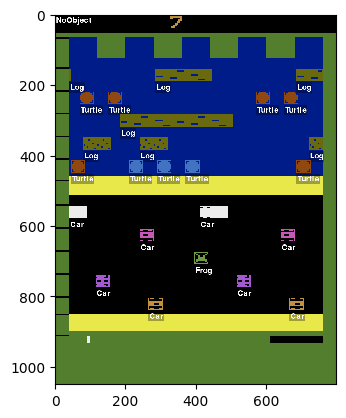


Step: 139 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (133, 161) size (8, 7), Car at (53, 161) size (8, 7), Car at (103, 148) size (8, 7), Car at (23, 148) size (8, 7), Car at (128, 122) size (8, 7), Car at (48, 122) size (8, 7), Car at (82, 109) size (16, 7), Car at (8, 109) size (10, 7), Log at (48, 70) size (16, 7), Log at (16, 70) size (16, 7), Log at (144, 70) size (8, 7), Log at (37, 57) size (64, 7), Log at (8, 31) size (1, 7), Log at (137, 31) size (15, 7), Log at (57, 31) size (32, 7), Turtle at (137, 83) size (8, 7), Turtle at (9, 83) size (8, 7), Turtle at (74, 83) size (8, 7), Turtle at (58, 83) size (8, 7), Turtle at (42, 83) size (8, 7), Turtle at (30, 44) size (8, 7), Turtle at (14, 44) size (8, 7), Turtle at (130, 44) size (8, 7), Turtle at (114, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and heig

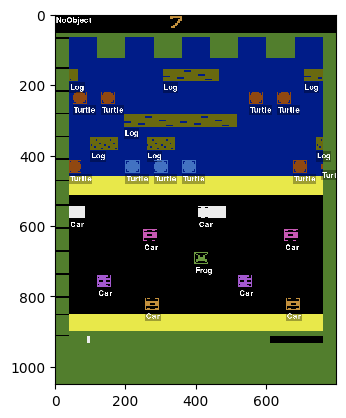


Step: 140 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (131, 161) size (8, 7), Car at (51, 161) size (8, 7), Car at (104, 148) size (8, 7), Car at (24, 148) size (8, 7), Car at (130, 122) size (8, 7), Car at (50, 122) size (8, 7), Car at (81, 109) size (16, 7), Car at (8, 109) size (9, 7), Log at (52, 70) size (16, 7), Log at (20, 70) size (16, 7), Log at (148, 70) size (4, 7), Log at (39, 57) size (64, 7), Log at (8, 31) size (5, 7), Log at (141, 31) size (11, 7), Log at (61, 31) size (32, 7), Turtle at (135, 83) size (8, 7), Turtle at (8, 83) size (7, 7), Turtle at (151, 85) size (1, 3), Turtle at (72, 83) size (8, 7), Turtle at (56, 83) size (8, 7), Turtle at (40, 83) size (8, 7), Turtle at (26, 44) size (8, 7), Turtle at (10, 44) size (8, 7), Turtle at (126, 44) size (8, 7), Turtle at (110, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions 

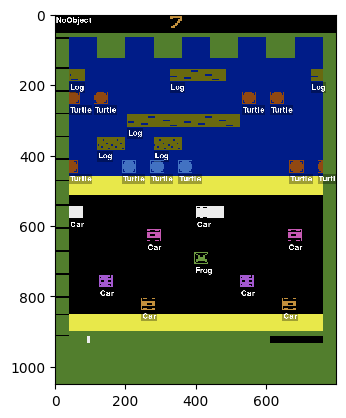


Step: 141 action: UP Game objects: Frog at (79, 135) size (8, 7), Car at (129, 161) size (8, 7), Car at (49, 161) size (8, 7), Car at (105, 148) size (8, 7), Car at (25, 148) size (8, 7), Car at (132, 122) size (8, 7), Car at (52, 122) size (8, 7), Car at (80, 109) size (16, 7), Car at (8, 109) size (8, 7), Log at (56, 70) size (16, 7), Log at (24, 70) size (16, 7), Log at (41, 57) size (64, 7), Log at (8, 31) size (9, 7), Log at (145, 31) size (7, 7), Log at (65, 31) size (32, 7), Turtle at (133, 83) size (8, 7), Turtle at (8, 83) size (5, 7), Turtle at (149, 83) size (3, 7), Turtle at (70, 83) size (8, 7), Turtle at (54, 83) size (8, 7), Turtle at (38, 83) size (8, 7), Turtle at (22, 44) size (8, 7), Turtle at (8, 44) size (6, 7), Turtle at (122, 44) size (8, 7), Turtle at (106, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and heig

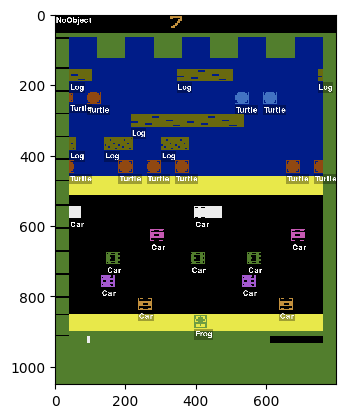


Step: 142 action: UP Game objects: Frog at (79, 171) size (7, 7), Car at (127, 161) size (8, 7), Car at (47, 161) size (8, 7), Car at (106, 148) size (8, 7), Car at (26, 148) size (8, 7), Car at (109, 135) size (8, 7), Car at (77, 135) size (8, 7), Car at (29, 135) size (8, 7), Car at (134, 122) size (8, 7), Car at (54, 122) size (8, 7), Car at (79, 109) size (16, 7), Car at (8, 109) size (7, 7), Log at (60, 70) size (16, 7), Log at (28, 70) size (16, 7), Log at (8, 70) size (4, 7), Log at (43, 57) size (64, 7), Log at (8, 31) size (13, 7), Log at (149, 31) size (3, 7), Log at (69, 31) size (32, 7), Turtle at (131, 83) size (8, 7), Turtle at (8, 83) size (3, 7), Turtle at (147, 83) size (5, 7), Turtle at (68, 83) size (8, 7), Turtle at (52, 83) size (8, 7), Turtle at (36, 83) size (8, 7), Turtle at (18, 44) size (8, 7), Turtle at (8, 45) size (2, 5), Turtle at (118, 44) size (8, 7), Turtle at (102, 44) size (8, 7)
You are a game playing assistant and will be provided the position of a

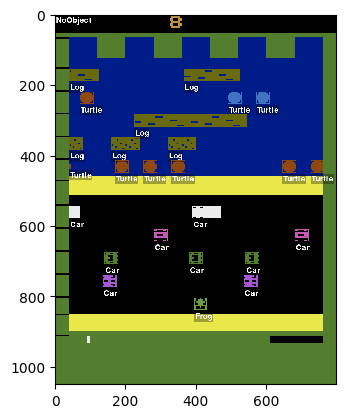


Step: 143 action: UP Game objects: Frog at (79, 161) size (7, 7), Car at (107, 148) size (8, 7), Car at (27, 148) size (8, 7), Car at (108, 135) size (8, 7), Car at (76, 135) size (8, 7), Car at (28, 135) size (8, 7), Car at (136, 122) size (8, 7), Car at (56, 122) size (8, 7), Car at (78, 109) size (16, 7), Car at (8, 109) size (6, 7), Log at (64, 70) size (16, 7), Log at (32, 70) size (16, 7), Log at (8, 70) size (8, 7), Log at (45, 57) size (64, 7), Log at (8, 31) size (17, 7), Log at (73, 31) size (32, 7), Turtle at (129, 83) size (8, 7), Turtle at (8, 85) size (1, 3), Turtle at (145, 83) size (7, 7), Turtle at (66, 83) size (8, 7), Turtle at (50, 83) size (8, 7), Turtle at (34, 83) size (8, 7), Turtle at (14, 44) size (8, 7), Turtle at (114, 44) size (8, 7), Turtle at (98, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height 

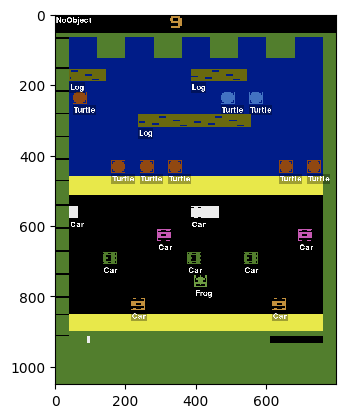


Step: 144 action: UP Game objects: Frog at (79, 148) size (7, 7), Car at (123, 161) size (8, 7), Car at (43, 161) size (8, 7), Car at (107, 135) size (8, 7), Car at (75, 135) size (8, 7), Car at (27, 135) size (8, 7), Car at (138, 122) size (8, 7), Car at (58, 122) size (8, 7), Car at (77, 109) size (16, 7), Car at (8, 109) size (5, 7), Log at (47, 57) size (64, 7), Log at (8, 31) size (21, 7), Log at (77, 31) size (32, 7), Turtle at (127, 83) size (8, 7), Turtle at (143, 83) size (8, 7), Turtle at (64, 83) size (8, 7), Turtle at (48, 83) size (8, 7), Turtle at (32, 83) size (8, 7), Turtle at (10, 44) size (8, 7), Turtle at (110, 44) size (8, 7), Turtle at (94, 44) size (8, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you believe to be the best action I could take to beat the game.
Think 

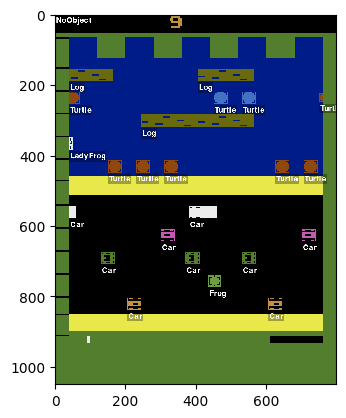


Step: 145 action: RIGHT Game objects: Frog at (87, 148) size (7, 7), Car at (121, 161) size (8, 7), Car at (41, 161) size (8, 7), Car at (106, 135) size (8, 7), Car at (74, 135) size (8, 7), Car at (26, 135) size (8, 7), Car at (140, 122) size (8, 7), Car at (60, 122) size (8, 7), Car at (76, 109) size (16, 7), Car at (8, 109) size (4, 7), Log at (49, 57) size (64, 7), Log at (8, 31) size (25, 7), Log at (81, 31) size (32, 7), Turtle at (125, 83) size (8, 7), Turtle at (141, 83) size (8, 7), Turtle at (62, 83) size (8, 7), Turtle at (46, 83) size (8, 7), Turtle at (30, 83) size (8, 7), Turtle at (8, 44) size (6, 7), Turtle at (150, 45) size (2, 5), Turtle at (106, 44) size (8, 7), Turtle at (90, 44) size (8, 7), LadyFrog at (8, 70) size (2, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you

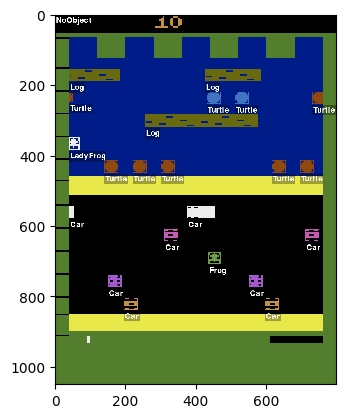


Step: 146 action: UP Game objects: Frog at (87, 135) size (7, 7), Car at (119, 161) size (8, 7), Car at (39, 161) size (8, 7), Car at (110, 148) size (8, 7), Car at (30, 148) size (8, 7), Car at (142, 122) size (8, 7), Car at (62, 122) size (8, 7), Car at (75, 109) size (16, 7), Car at (8, 109) size (3, 7), Log at (51, 57) size (64, 7), Log at (8, 31) size (29, 7), Log at (85, 31) size (32, 7), Turtle at (123, 83) size (8, 7), Turtle at (139, 83) size (8, 7), Turtle at (60, 83) size (8, 7), Turtle at (44, 83) size (8, 7), Turtle at (28, 83) size (8, 7), Turtle at (8, 45) size (2, 5), Turtle at (146, 44) size (6, 7), Turtle at (102, 44) size (8, 7), Turtle at (86, 44) size (8, 7), LadyFrog at (8, 70) size (6, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you believe to be the best action I 

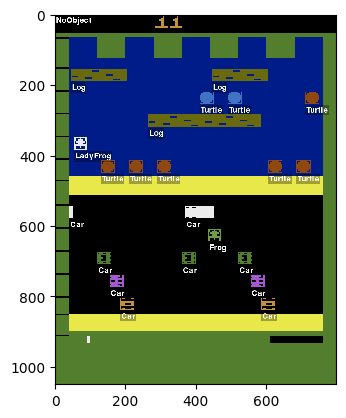


Step: 147 action: UP Game objects: Frog at (87, 122) size (7, 7), Car at (117, 161) size (8, 7), Car at (37, 161) size (8, 7), Car at (111, 148) size (8, 7), Car at (31, 148) size (8, 7), Car at (104, 135) size (8, 7), Car at (72, 135) size (8, 7), Car at (24, 135) size (8, 7), Car at (74, 109) size (16, 7), Car at (8, 109) size (2, 7), Log at (53, 57) size (64, 7), Log at (9, 31) size (32, 7), Log at (89, 31) size (32, 7), Turtle at (121, 83) size (8, 7), Turtle at (137, 83) size (8, 7), Turtle at (58, 83) size (8, 7), Turtle at (42, 83) size (8, 7), Turtle at (26, 83) size (8, 7), Turtle at (142, 44) size (8, 7), Turtle at (98, 44) size (8, 7), Turtle at (82, 44) size (8, 7), LadyFrog at (11, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you believe to be the best action I c

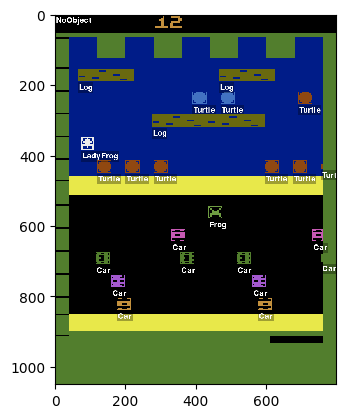


Step: 148 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (115, 161) size (8, 7), Car at (35, 161) size (8, 7), Car at (112, 148) size (8, 7), Car at (32, 148) size (8, 7), Car at (103, 135) size (8, 7), Car at (71, 135) size (8, 7), Car at (23, 135) size (8, 7), Car at (151, 136) size (1, 5), Car at (146, 122) size (6, 7), Car at (66, 122) size (8, 7), Log at (55, 57) size (64, 7), Log at (13, 31) size (32, 7), Log at (93, 31) size (32, 7), Turtle at (119, 83) size (8, 7), Turtle at (151, 85) size (1, 3), Turtle at (135, 83) size (8, 7), Turtle at (56, 83) size (8, 7), Turtle at (40, 83) size (8, 7), Turtle at (24, 83) size (8, 7), Turtle at (138, 44) size (8, 7), Turtle at (94, 44) size (8, 7), Turtle at (78, 44) size (8, 7), LadyFrog at (15, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goa

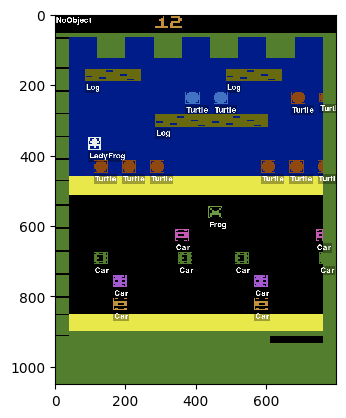


Step: 149 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (113, 161) size (8, 7), Car at (33, 161) size (8, 7), Car at (113, 148) size (8, 7), Car at (33, 148) size (8, 7), Car at (102, 135) size (8, 7), Car at (70, 135) size (8, 7), Car at (22, 135) size (8, 7), Car at (150, 135) size (2, 7), Car at (148, 122) size (4, 7), Car at (68, 122) size (8, 7), Log at (57, 57) size (64, 7), Log at (17, 31) size (32, 7), Log at (97, 31) size (32, 7), Turtle at (117, 83) size (8, 7), Turtle at (149, 83) size (3, 7), Turtle at (133, 83) size (8, 7), Turtle at (54, 83) size (8, 7), Turtle at (38, 83) size (8, 7), Turtle at (22, 83) size (8, 7), Turtle at (150, 45) size (2, 5), Turtle at (134, 44) size (8, 7), Turtle at (90, 44) size (8, 7), Turtle at (74, 44) size (8, 7), LadyFrog at (19, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their wid

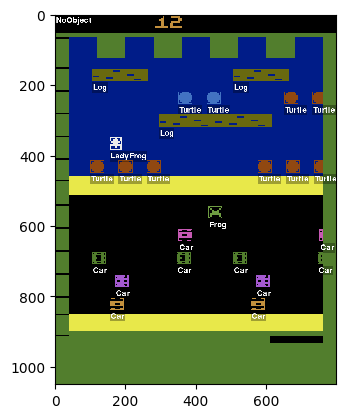


Step: 150 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (111, 161) size (8, 7), Car at (31, 161) size (8, 7), Car at (114, 148) size (8, 7), Car at (34, 148) size (8, 7), Car at (101, 135) size (8, 7), Car at (69, 135) size (8, 7), Car at (21, 135) size (8, 7), Car at (149, 135) size (3, 7), Car at (150, 122) size (2, 7), Car at (70, 122) size (8, 7), Log at (59, 57) size (64, 7), Log at (21, 31) size (32, 7), Log at (101, 31) size (32, 7), Turtle at (115, 83) size (8, 7), Turtle at (147, 83) size (5, 7), Turtle at (131, 83) size (8, 7), Turtle at (52, 83) size (8, 7), Turtle at (36, 83) size (8, 7), Turtle at (20, 83) size (8, 7), Turtle at (146, 44) size (6, 7), Turtle at (130, 44) size (8, 7), Turtle at (86, 44) size (8, 7), Turtle at (70, 44) size (8, 7), LadyFrog at (31, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their wi

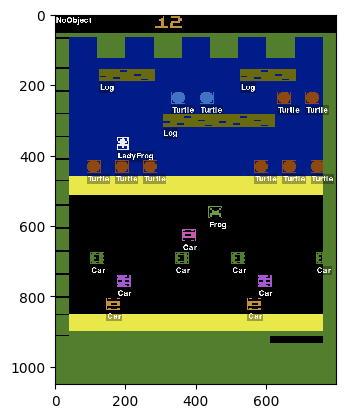


Step: 151 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (109, 161) size (8, 7), Car at (29, 161) size (8, 7), Car at (115, 148) size (8, 7), Car at (35, 148) size (8, 7), Car at (100, 135) size (8, 7), Car at (68, 135) size (8, 7), Car at (20, 135) size (8, 7), Car at (148, 135) size (4, 7), Car at (72, 122) size (8, 7), Log at (61, 57) size (64, 7), Log at (25, 31) size (32, 7), Log at (105, 31) size (32, 7), Turtle at (113, 83) size (8, 7), Turtle at (145, 83) size (7, 7), Turtle at (129, 83) size (8, 7), Turtle at (50, 83) size (8, 7), Turtle at (34, 83) size (8, 7), Turtle at (18, 83) size (8, 7), Turtle at (142, 44) size (8, 7), Turtle at (126, 44) size (8, 7), Turtle at (82, 44) size (8, 7), Turtle at (66, 44) size (8, 7), LadyFrog at (35, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your 

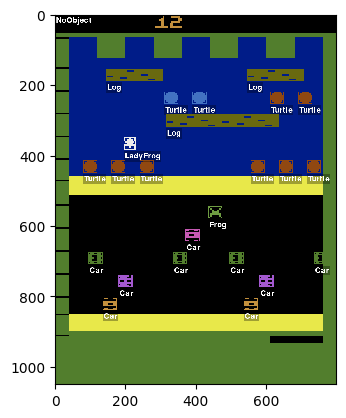


Step: 152 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (107, 161) size (8, 7), Car at (27, 161) size (8, 7), Car at (116, 148) size (8, 7), Car at (36, 148) size (8, 7), Car at (99, 135) size (8, 7), Car at (67, 135) size (8, 7), Car at (19, 135) size (8, 7), Car at (147, 135) size (5, 7), Car at (74, 122) size (8, 7), Log at (63, 57) size (64, 7), Log at (29, 31) size (32, 7), Log at (109, 31) size (32, 7), Turtle at (111, 83) size (8, 7), Turtle at (143, 83) size (8, 7), Turtle at (127, 83) size (8, 7), Turtle at (48, 83) size (8, 7), Turtle at (32, 83) size (8, 7), Turtle at (16, 83) size (8, 7), Turtle at (138, 44) size (8, 7), Turtle at (122, 44) size (8, 7), Turtle at (78, 44) size (8, 7), Turtle at (62, 44) size (8, 7), LadyFrog at (39, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your g

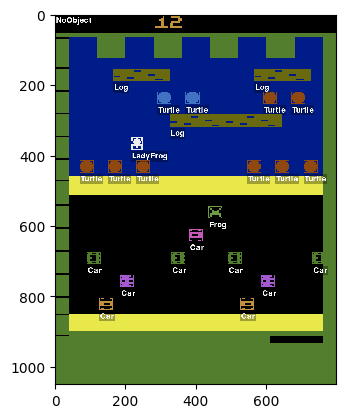


Step: 153 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (105, 161) size (8, 7), Car at (25, 161) size (8, 7), Car at (117, 148) size (8, 7), Car at (37, 148) size (8, 7), Car at (98, 135) size (8, 7), Car at (66, 135) size (8, 7), Car at (18, 135) size (8, 7), Car at (146, 135) size (6, 7), Car at (76, 122) size (8, 7), Log at (65, 57) size (64, 7), Log at (33, 31) size (32, 7), Log at (113, 31) size (32, 7), Turtle at (109, 83) size (8, 7), Turtle at (141, 83) size (8, 7), Turtle at (125, 83) size (8, 7), Turtle at (46, 83) size (8, 7), Turtle at (30, 83) size (8, 7), Turtle at (14, 83) size (8, 7), Turtle at (134, 44) size (8, 7), Turtle at (118, 44) size (8, 7), Turtle at (74, 44) size (8, 7), Turtle at (58, 44) size (8, 7), LadyFrog at (43, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your g

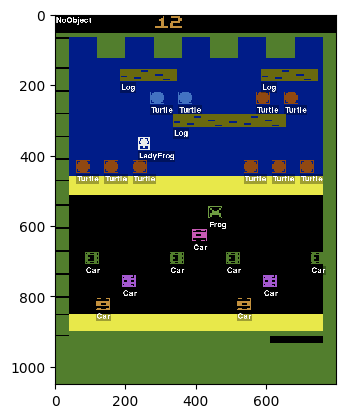


Step: 154 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (103, 161) size (8, 7), Car at (23, 161) size (8, 7), Car at (118, 148) size (8, 7), Car at (38, 148) size (8, 7), Car at (97, 135) size (8, 7), Car at (65, 135) size (8, 7), Car at (17, 135) size (8, 7), Car at (145, 135) size (7, 7), Car at (78, 122) size (8, 7), Log at (67, 57) size (64, 7), Log at (37, 31) size (32, 7), Log at (117, 31) size (32, 7), Turtle at (107, 83) size (8, 7), Turtle at (139, 83) size (8, 7), Turtle at (123, 83) size (8, 7), Turtle at (44, 83) size (8, 7), Turtle at (28, 83) size (8, 7), Turtle at (12, 83) size (8, 7), Turtle at (130, 44) size (8, 7), Turtle at (114, 44) size (8, 7), Turtle at (70, 44) size (8, 7), Turtle at (54, 44) size (8, 7), LadyFrog at (47, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your g

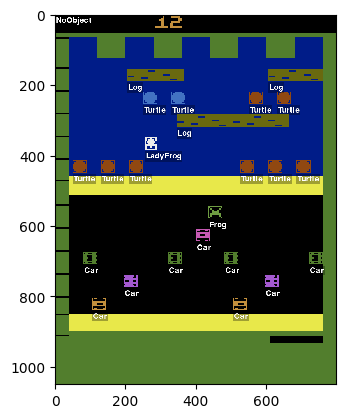


Step: 155 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (101, 161) size (8, 7), Car at (21, 161) size (8, 7), Car at (119, 148) size (8, 7), Car at (39, 148) size (8, 7), Car at (96, 135) size (8, 7), Car at (64, 135) size (8, 7), Car at (16, 135) size (8, 7), Car at (144, 135) size (8, 7), Car at (80, 122) size (8, 7), Log at (69, 57) size (64, 7), Log at (41, 31) size (32, 7), Log at (121, 31) size (31, 7), Turtle at (105, 83) size (8, 7), Turtle at (137, 83) size (8, 7), Turtle at (121, 83) size (8, 7), Turtle at (42, 83) size (8, 7), Turtle at (26, 83) size (8, 7), Turtle at (10, 83) size (8, 7), Turtle at (126, 44) size (8, 7), Turtle at (110, 44) size (8, 7), Turtle at (66, 44) size (8, 7), Turtle at (50, 44) size (8, 7), LadyFrog at (51, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your g

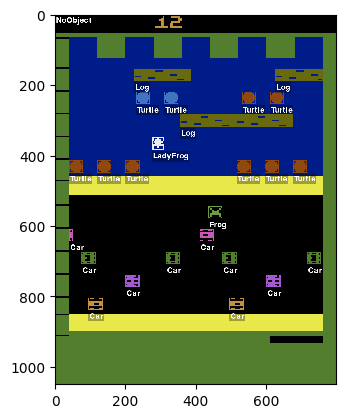


Step: 156 action: UP Game objects: Frog at (87, 109) size (8, 7), Car at (99, 161) size (8, 7), Car at (19, 161) size (8, 7), Car at (120, 148) size (8, 7), Car at (40, 148) size (8, 7), Car at (95, 135) size (8, 7), Car at (63, 135) size (8, 7), Car at (15, 135) size (8, 7), Car at (143, 135) size (8, 7), Car at (8, 122) size (2, 7), Car at (82, 122) size (8, 7), Log at (71, 57) size (64, 7), Log at (45, 31) size (32, 7), Log at (125, 31) size (27, 7), Turtle at (103, 83) size (8, 7), Turtle at (135, 83) size (8, 7), Turtle at (119, 83) size (8, 7), Turtle at (40, 83) size (8, 7), Turtle at (24, 83) size (8, 7), Turtle at (8, 83) size (8, 7), Turtle at (122, 44) size (8, 7), Turtle at (106, 44) size (8, 7), Turtle at (62, 44) size (8, 7), Turtle at (46, 44) size (8, 7), LadyFrog at (55, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width a

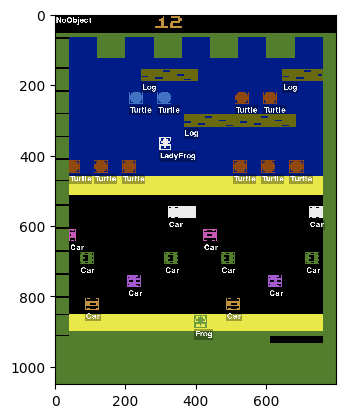


Step: 157 action: UP Game objects: Frog at (79, 171) size (7, 7), Car at (97, 161) size (8, 7), Car at (17, 161) size (8, 7), Car at (121, 148) size (8, 7), Car at (41, 148) size (8, 7), Car at (94, 135) size (8, 7), Car at (62, 135) size (8, 7), Car at (14, 135) size (8, 7), Car at (142, 135) size (8, 7), Car at (8, 122) size (4, 7), Car at (84, 122) size (8, 7), Car at (144, 109) size (8, 7), Car at (64, 109) size (16, 7), Log at (73, 57) size (64, 7), Log at (49, 31) size (32, 7), Log at (129, 31) size (23, 7), Turtle at (101, 83) size (8, 7), Turtle at (133, 83) size (8, 7), Turtle at (117, 83) size (8, 7), Turtle at (38, 83) size (8, 7), Turtle at (22, 83) size (8, 7), Turtle at (8, 83) size (6, 7), Turtle at (118, 44) size (8, 7), Turtle at (102, 44) size (8, 7), Turtle at (58, 44) size (8, 7), Turtle at (42, 44) size (8, 7), LadyFrog at (59, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by thei

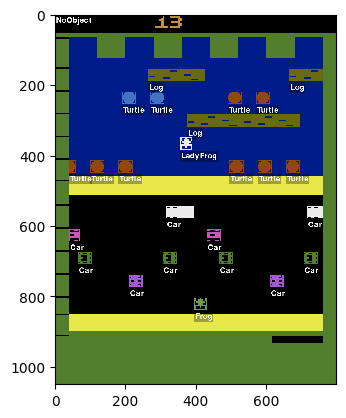


Step: 158 action: UP Game objects: Frog at (79, 161) size (7, 7), Car at (122, 148) size (8, 7), Car at (42, 148) size (8, 7), Car at (93, 135) size (8, 7), Car at (61, 135) size (8, 7), Car at (13, 135) size (8, 7), Car at (141, 135) size (8, 7), Car at (8, 122) size (6, 7), Car at (86, 122) size (8, 7), Car at (143, 109) size (9, 7), Car at (63, 109) size (16, 7), Log at (75, 57) size (64, 7), Log at (53, 31) size (32, 7), Log at (133, 31) size (19, 7), Turtle at (99, 83) size (8, 7), Turtle at (131, 83) size (8, 7), Turtle at (115, 83) size (8, 7), Turtle at (36, 83) size (8, 7), Turtle at (20, 83) size (8, 7), Turtle at (8, 83) size (4, 7), Turtle at (114, 44) size (8, 7), Turtle at (98, 44) size (8, 7), Turtle at (54, 44) size (8, 7), Turtle at (38, 44) size (8, 7), LadyFrog at (71, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width a

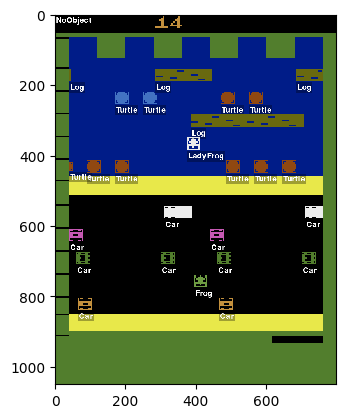


Step: 159 action: UP Game objects: Frog at (79, 148) size (7, 7), Car at (93, 161) size (8, 7), Car at (13, 161) size (8, 7), Car at (92, 135) size (8, 7), Car at (60, 135) size (8, 7), Car at (12, 135) size (8, 7), Car at (140, 135) size (8, 7), Car at (8, 122) size (8, 7), Car at (88, 122) size (8, 7), Car at (142, 109) size (10, 7), Car at (62, 109) size (16, 7), Log at (77, 57) size (64, 7), Log at (57, 31) size (32, 7), Log at (8, 31) size (1, 7), Log at (137, 31) size (15, 7), Turtle at (97, 83) size (8, 7), Turtle at (129, 83) size (8, 7), Turtle at (113, 83) size (8, 7), Turtle at (34, 83) size (8, 7), Turtle at (18, 83) size (8, 7), Turtle at (8, 84) size (2, 5), Turtle at (110, 44) size (8, 7), Turtle at (94, 44) size (8, 7), Turtle at (50, 44) size (8, 7), Turtle at (34, 44) size (8, 7), LadyFrog at (75, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positio

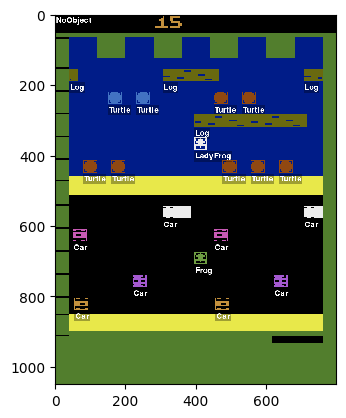


Step: 160 action: UP Game objects: Frog at (79, 135) size (7, 7), Car at (91, 161) size (8, 7), Car at (11, 161) size (8, 7), Car at (124, 148) size (8, 7), Car at (44, 148) size (8, 7), Car at (10, 122) size (8, 7), Car at (90, 122) size (8, 7), Car at (141, 109) size (11, 7), Car at (61, 109) size (16, 7), Log at (79, 57) size (64, 7), Log at (61, 31) size (32, 7), Log at (8, 31) size (5, 7), Log at (141, 31) size (11, 7), Turtle at (95, 83) size (8, 7), Turtle at (127, 83) size (8, 7), Turtle at (111, 83) size (8, 7), Turtle at (32, 83) size (8, 7), Turtle at (16, 83) size (8, 7), Turtle at (106, 44) size (8, 7), Turtle at (90, 44) size (8, 7), Turtle at (46, 44) size (8, 7), Turtle at (30, 44) size (8, 7), LadyFrog at (79, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you 

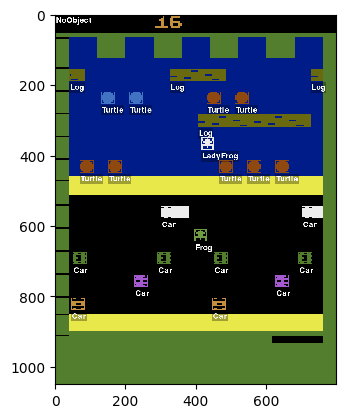


Step: 161 action: UP Game objects: Frog at (79, 122) size (7, 7), Car at (89, 161) size (8, 7), Car at (9, 161) size (8, 7), Car at (125, 148) size (8, 7), Car at (45, 148) size (8, 7), Car at (138, 135) size (8, 7), Car at (90, 135) size (8, 7), Car at (58, 135) size (8, 7), Car at (10, 135) size (8, 7), Car at (140, 109) size (12, 7), Car at (60, 109) size (16, 7), Log at (81, 57) size (64, 7), Log at (65, 31) size (32, 7), Log at (8, 31) size (9, 7), Log at (145, 31) size (7, 7), Turtle at (93, 83) size (8, 7), Turtle at (125, 83) size (8, 7), Turtle at (109, 83) size (8, 7), Turtle at (30, 83) size (8, 7), Turtle at (14, 83) size (8, 7), Turtle at (102, 44) size (8, 7), Turtle at (86, 44) size (8, 7), Turtle at (42, 44) size (8, 7), Turtle at (26, 44) size (8, 7), LadyFrog at (83, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and 

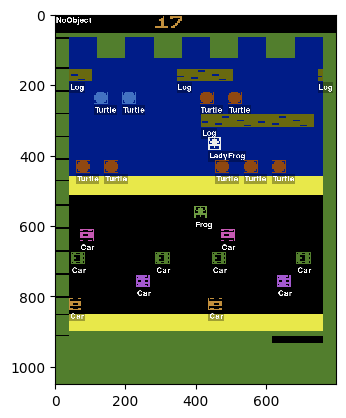


Step: 162 action: UP Game objects: Frog at (79, 109) size (7, 7), Car at (87, 161) size (8, 7), Car at (8, 161) size (7, 7), Car at (126, 148) size (8, 7), Car at (46, 148) size (8, 7), Car at (137, 135) size (8, 7), Car at (89, 135) size (8, 7), Car at (57, 135) size (8, 7), Car at (9, 135) size (8, 7), Car at (94, 122) size (8, 7), Car at (14, 122) size (8, 7), Log at (83, 57) size (64, 7), Log at (69, 31) size (32, 7), Log at (8, 31) size (13, 7), Log at (149, 31) size (3, 7), Turtle at (91, 83) size (8, 7), Turtle at (123, 83) size (8, 7), Turtle at (107, 83) size (8, 7), Turtle at (28, 83) size (8, 7), Turtle at (12, 83) size (8, 7), Turtle at (98, 44) size (8, 7), Turtle at (82, 44) size (8, 7), Turtle at (38, 44) size (8, 7), Turtle at (22, 44) size (8, 7), LadyFrog at (87, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and heig

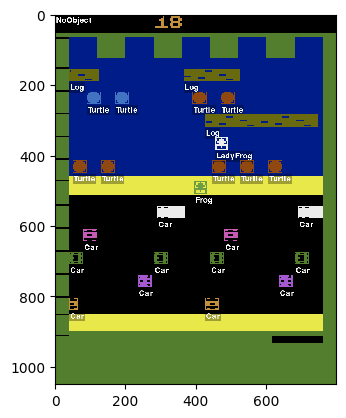


Step: 163 action: UP Game objects: Frog at (79, 95) size (7, 7), Car at (85, 161) size (8, 7), Car at (8, 161) size (5, 7), Car at (127, 148) size (8, 7), Car at (47, 148) size (8, 7), Car at (136, 135) size (8, 7), Car at (88, 135) size (8, 7), Car at (56, 135) size (8, 7), Car at (8, 135) size (8, 7), Car at (96, 122) size (8, 7), Car at (16, 122) size (8, 7), Car at (138, 109) size (14, 7), Car at (58, 109) size (16, 7), Log at (85, 57) size (64, 7), Log at (73, 31) size (32, 7), Log at (8, 31) size (17, 7), Turtle at (89, 83) size (8, 7), Turtle at (121, 83) size (8, 7), Turtle at (105, 83) size (8, 7), Turtle at (26, 83) size (8, 7), Turtle at (10, 83) size (8, 7), Turtle at (94, 44) size (8, 7), Turtle at (78, 44) size (8, 7), Turtle at (34, 44) size (8, 7), Turtle at (18, 44) size (8, 7), LadyFrog at (91, 70) size (7, 7)
You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions 

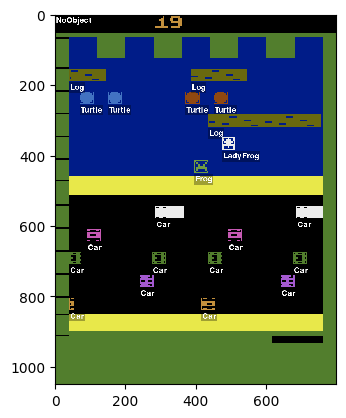

GAME ENDED
Total reward: 19.0


In [ ]:
state, info = env.reset()

max_steps = 1000
actions_dict = { "NOOP": 0, "UP": 1, "RIGHT": 2, "LEFT": 3, "DOWN": 4 }

def action_to_index(action: str) -> int:
    return actions_dict[action]

def index_to_action(index: int) -> str:
    return list(actions_dict.keys())[index]

state, info = env.reset()
trace = []
# demonstrations = load_demonstrations(process=process_images)[10:30]
demonstrations = []

# skip over initial 109 frames (with default frameskip=4) where control is not enabled
for step in range(109):
    state, reward, terminated, truncated, _ = env.step(0)
    env.detect_objects()
    objs = extract_objs(env)
    s = np.flip(np.rot90(env.render(), k=-1), axis=1)
    trace.append({'action': 0, 'frame': numpy_to_base64(s), 'objs': objs, 'reward': 0})

total_reward = 0
while step < max_steps:
    # with open('frogger_manual.txt', 'r') as f:
    #     prompt = f.read()
    prompt = f"""You are a game playing assistant and will be provided the position of all game objects. The game objects are given by their top-left corner's (x, y) positions followed by their width and height in (w, h). Your goal is to provide me with what you believe to be the best action I could take to beat the game.
Think about all possible actions and why each action is or is not the best action to take. I'm at step {step} and the potential actions I can take are NOOP, UP, RIGHT, LEFT, DOWN.
Provide output as a json structured as game_state: describe the current game state in detail, reasoning: reasoning for actions and why to choose an action, action: the chosen action."""

    action, llm_input, llm_output = call_openai(model, reasoning_effort, prompt, step, trace, demonstrations, resize_to, oc=True)
    action = action_to_index(action)

    state, reward, terminated, truncated, _ = env.step(action)
    env.detect_objects()
    objs = extract_objs(env)
    s = np.flip(np.rot90(env.render(), k=-1), axis=1)
    trace.append({'llm_input': llm_input, 'llm_output': llm_output, 'action': action, 'frame': numpy_to_base64(s), 'objs': objs, 'reward': reward})
    plt.figure()
    plt.imshow(s, interpolation='nearest')
    plt.show()
    total_reward += reward
    step += 1

    with open(f'traces/{model}_{reasoning_effort}.json', 'w+') as f:
        f.write(json.dumps(trace))

    if terminated or truncated:
        print('GAME ENDED')
        break

    state, reward, terminated, truncated, _ = env.step(0)
    total_reward += reward

env.close()
print(f'Total reward: {total_reward}')

In [5]:
# Reconstruct trace
with open(f'traces/{model}_{reasoning_effort}.json', 'r') as f:
    trace = json.load(f)
    frames = []
    for t in trace:
        image = base64_to_numpy(t['frame'])
        frames.append(image)
    frames_to_video(video_folder=f'traces', video_name=f'{model}_{reasoning_effort}', frames=frames, fps=15)

MoviePy - Building video traces/o3-mini-2025-01-31_low.mp4.
MoviePy - Writing video traces/o3-mini-2025-01-31_low.mp4



MoviePy - Done !
MoviePy - video ready traces/o3-mini-2025-01-31_low.mp4
